# Speech emotion recognition 
## using ESN-IP

---



In [ ]:
!pip install librosa

In [ ]:
# import libraries
import os

import numpy as np
import pandas as pd
import librosa   # to extract speech features
import soundfile  # to read sound file
import glob # to find files
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.metrics import accuracy_score # to measure how good we are
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
import math
import scipy.io
import scipy.linalg as la
import random
from scipy.special import softmax
from numpy import argmax
import matplotlib.pyplot as plt


In [ ]:
# download and extract dataset to current directory
def extract_dataset():
  if "download.zip" in os.listdir():
    print("Dataset already exist")

  else:  
    print("Downloading Emo-DB (40.5MB) ...")
    !wget http://emodb.bilderbar.info/download/download.zip
    print("Dataset is downloaded!")
    print("Now extracting the data ...")
    !unzip download.zip
    print("Extracting is done!")

  # determine the path of wav folder
  current_path = os.getcwd()
  print("currect path is ", current_path)
  location = os.path.join(current_path, "wav/")
  print("full path to dataset wav folder: ", location)

  # convert the dataset_files list into panda dataframe for better visualization
  dataset_files = os.listdir(location)
  
  return dataset_files

audio_files = extract_dataset()
# audio_files
  

=======================================

**How dataset looks like**

In [ ]:
# Get emotion labels
def get_emotions_speakers():
  emotion_encoding = {
    'W': 'Anger',
    'L': 'Bordom',
    'E': 'Disgust',
    'A': 'Anxiety/Fear',
    'F': 'Happienss',
    'T': 'Sadness',
    'N': 'Neutral'
  }

  emotion_codes = []
  df_names = pd.DataFrame(audio_files, columns=['File_names'])

  for file in df_names.File_names:
    # print(file)
    emotion_codes.append(file[-1-5])
  df_names['Emotion_codes'] = emotion_codes

  emotion_names = []
  for emo in df_names.Emotion_codes:
    emotion_names.append(emotion_encoding[emo])
  df_names['Emotions'] = emotion_names

  speaker_code = []
  for sp in df_names.File_names:
    speaker_code.append(sp[-1-10:-1-8])
  df_names['Speaker_codes'] = speaker_code
  return df_names

# invoke the function
df_names = get_emotions_speakers()
df_names.head(20)

,File_names,Emotion_codes,Emotions,Speaker_codes
0,14a01Wc.wav,W,Anger,14
1,12a01Lb.wav,L,Bordom,12
2,16b10Wb.wav,W,Anger,16
3,14a05Tc.wav,T,Sadness,14
4,13a05Lc.wav,L,Bordom,13
5,09a02Eb.wav,E,Disgust,09
6,03a02Ta.wav,T,Sadness,03
7,14a04Aa.wav,A,Anxiety/Fear,14
8,08b02Tc.wav,T,Sadness,08
9,14a04Tc.wav,T,Sadness,14


### Dataset preprocessing 
feature extraction and emotion name

The feature extraction code is referenced from the following website

https://www.thepythoncode.com/article/building-a-speech-emotion-recognizer-using-sklearn

In [ ]:
# Extracting features of the sound to give them as inputs to the ESN-IP
# librosa is a library of package used to extract sound/speech features
"""
      Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """

def extract_features(file_name, **kwargs):
  mfcc = kwargs.get('mfcc')
  chroma = kwargs.get('chroma')
  mel = kwargs.get('mel')
  contrast = kwargs.get("contrast")
  tonnetz = kwargs.get("tonnetz")

  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate = sound_file.samplerate
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
  return result

# Get emotion labels
emotion_encoding = {
  'W': 'Anger',
  'L': 'Bordom',
  'E': 'Disgust',
  'A': 'Anxiety/Fear',
  'F': 'Happienss',
  'T': 'Sadness',
  'N': 'Neutral'
}

# Rerwite the previous funtion to work with the actual code
# define a function to get emotion names from the code letters 
# in the dic emotion_encoding

def get_emotions(file_name):
  emotion_code = file_name[-1-5]
  emotion_name = emotion_encoding[emotion_code]
  return emotion_name


# append the sound features (the inputs) in x and labels in y
x, y_labels = [], []

for file in glob.glob("wav/*.wav"):
  # extract features by invoking the previous function
  features = extract_features(file, mfcc=True, chroma=True, mel=True)
  x.append(features)

  # from file name get the emotion name
  file_name = os.path.basename(file)
  emotion_name = get_emotions(file_name)
  y_labels.append(emotion_name)


In [ ]:
# convert x to np.array
x = np.array(x)
print(x.shape)
print("The extracted sound features in numerical format:\n", x)
print("========================================================\n")
# Label encoding the output labels into numerical values

# 1.convert y_labels to np.array
y_labels = np.array(y_labels)
# print(y_labels)

# 2. encode labels to numerical values
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

labelencoder = LabelEncoder()
y_int = labelencoder.fit_transform(y_labels)
# print(y_int)

# # 3. reshape y and binary encoded:
onehot_encoder = OneHotEncoder(sparse=False)

# # y_int = y_int.reshape(-1,1)
y_int = y_int.reshape(len(y_int),1)
y_binary = onehot_encoder.fit_transform(y_int)
print(y_binary.shape)
print("The emotions in numerical class form:\n", y_binary)
y = y_binary

(535, 180)
The extracted sound features in numerical format:
 [[-2.03727509e+02  4.66885529e+01 -2.60267372e+01 ...  1.21456617e-02
   4.98131011e-03  2.44461070e-03]
 [-1.79807083e+02  9.96604309e+01 -8.50348759e+00 ...  1.06516294e-03
   5.52454381e-04  2.52343394e-04]
 [-1.95794830e+02  7.62879276e+00 -3.18221474e+01 ...  9.20019299e-03
   4.67725750e-03  1.79915433e-03]
 ...
 [-2.15402039e+02  8.73074799e+01  3.10500984e+01 ...  4.36414331e-02
   1.98393203e-02  1.05115157e-02]
 [-1.79464874e+02  1.07644226e+02  1.09269075e+01 ...  1.10072950e-02
   4.77286382e-03  3.22845811e-03]
 [-1.88663147e+02  4.52506027e+01 -3.09450603e+00 ...  6.19737990e-02
   3.24838534e-02  1.15055023e-02]]

(535, 7)
The emotions in numerical class form:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Split the data for training
# just input the x data as a numpy array cause it has many columns  get the test size back to 0.25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 7)



In [ ]:
print(x_train.shape)
print(y_train.shape)

(374, 180)
(374, 7)


In [ ]:
print(x_test.shape)
print(y_test.shape)


(161, 180)
(161, 7)


### ESN-IP

The following code is mainly based on matlab code by Andrea-V, but it is rewritten in python with some modifications to work with the previous dataset and classification problem.

https://github.com/Andrea-V/Echo-State-Network-with-Intrinsic-Plasticity



and some guidance from pyESN.py class by cknd

https://github.com/cknd/pyESN




In [ ]:
#random no. b/w ]-5, 5[ 
x = 10 * np.random.rand(2,3) - 5 
x

#random no. b/w ]-0.5, 0.5[ 
x = 1 * np.random.rand(2,3) - 0.5 
x  

#random no. b/w ]-0.1, 0.1[ 
x = 0.2 * np.random.rand(2,3) - 0.1 
x  

array([[-0.07466781,  0.03940979,  0.07482152],
       [ 0.06948728,  0.01826405, -0.07432854]])

In [ ]:
"""
inputs: array of dimensions (N_training_samples x n_inputs)
outputs: array of dimension (N_training_samples x n_outputs)

n_inputs = input_features
n_outputs = output_classes
==============================================================
input_features = the number of features (cols) for each row (sample)
res_units = internal units = no. of reservoir units
spectral_radius of reservoir's weight matrix
scaling = input scaling
connectivity = the connection threshold between the neurons or nodes = rate 
of reservoir's units.
lambda = Regularization rate

nepoch = Number of epochs of IP pretraining
mu = mean of target Normal distribution.
sigma = the variance of target normal distribution.
eta = learning rate
lambda1 = regularization rate.
samples, features = train_x.shape   
#sample = rows & features = inputs = cols

"""

class ESN(object):
  def __init__(self, x_train, y_train, 
               res_units = 500, spectral_radius=0.99, scaling=0.2, 
               connectivity=0.3, eta=5e-4, mu=0, sigma=0.1, 
               nepochs = 20, lambda1 = 500, IP = True, 
               teacher_forcing = True):
    # Initialize attributes / data fields / parameters
    self._x_train = x_train
    self._y_train = y_train
    self._input_features = x_train.shape[1]
    self._output_classes = y_train.shape[1]
    self._res_units = res_units
    self._spectral_radius = spectral_radius
    self._scaling = scaling
    self._connectivity = connectivity
    self._with_IP = IP
    self._teacher_forcing = teacher_forcing
    self._eta = eta
    self._mu = mu
    self._sigma = sigma
    self._nepochs = nepochs
    self._lambda1 = lambda1
    self.esn_init_weights()
    self.esn_train_ip(x_train)
  # First: Initialize the esn by generating initial w_in and w_hat:     
  def esn_init_weights(self):
    # 1. Generate input weights w_in
    self.w_in = self._scaling * np.random.rand(self._res_units, self._input_features) - 0.1

    # 2. now generate the internal weights or reservoir weights w_hat
    # we do not want 0 as max eigenvalue 
    max_eigen_value = 0

    while max_eigen_value == 0:
      w_hat = np.random.rand(self._res_units, self._res_units) - 0.5
      
      # delete the weights / connections given by self._connectivity by setting them to 0
      w_hat[np.random.rand(self._res_units, self._res_units) > self._connectivity] = 0

      # w_hat should be square matrix to find the eigen value.
      max_eigen_value = max(abs(np.linalg.eigvals(w_hat)))
      # print("current max eigen value of w_hat is: ", max_eigen_value)
    # echo state property / rescale the weights to reach the requested spectral radius
    self.w_hat = w_hat * (self._spectral_radius / max_eigen_value) # necessary condition

    # 3. generate random feedback (teacher forcing) weights
    self.w_feedb = np.random.rand(self._res_units, self._output_classes) * 2 - 1
    np.savetxt("w_hat.csv", self.w_hat, delimiter=",")
    return self.w_hat
  #######################################################################
  # Second: Train IP - Find the IP parameters a and b: 
  def esn_train_ip(self,x):
    # x: samples on the columns
    tol = 1e-7

    # init IP params
    ip_a = np.ones((len(self.w_hat),1))
    ip_b = np.zeros((len(self.w_hat),1))

    for epoch in range(self._nepochs):
      old_a = ip_a
      old_b = ip_b

      for j in range(len(x)):
        if j == 0:
          x1 = self.w_in @ x[j, :].reshape(-1,1) # it should be reshape 1,-1 and the reshape -1, 1 convert it again to 1 dim array with shape(4,)  
          # print(x1)
        else:
          x1 = (self.w_in @ x[j, :].reshape(-1,1)) + (self.w_hat @ last_state)
              
        # save last echo states (needed for x(t+1) so y is x(t+1))
        y = np.tanh(ip_a * x1 + ip_b)
        last_state = y
  
        # IP delta rule
        zs = np.zeros((len(self.w_hat),1))

        # ip_b
        delta_b = - self._eta * ( - (zs + self._mu/self._sigma**2) + y/self._sigma**2 * (2 * self._sigma**2 + 1 - y**2 + self._mu*y) )
        ip_b = ip_b + delta_b

        #ip_a
        delta_a = self._eta / ip_a + delta_b * x1
        ip_a = ip_a + delta_a

      # stop iterations if the changes of ip (old and new) are negligible (very small)
      norm_a = np.linalg.norm(old_a - ip_a,2)
      norm_b = np.linalg.norm(old_b - ip_b,2)
      if norm_a < tol and norm_b < tol:
        break

    self.ip_a = np.transpose(ip_a)
    self.ip_b = np.transpose(ip_b)
    # return self.ip_a, self.ip_b

  #######################################################################
  # Third define the esn states 
  def esn_states(self,x):
    # create 2D empty numpy array
    if x.ndim < 2:
      inputs = np.reshape(x, (len(x), -1))

    # allocate memory for the collected states matrix
    states = np.zeros((x.shape[0], self._res_units))

    y = self._y_train
    # calculate states using only IP params
    if self._with_IP and self._teacher_forcing == False:  
      print("only IP....")    
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :])  
        state = np.tanh(self.ip_a * state + self.ip_b)
        states[j] = state

    # calculate states without using IP params or teacher forcing
    elif self._with_IP == False and self._teacher_forcing == False:
      print("no IP, no teacher forcing....")  
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :])
        state = np.tanh(state)
        states[j] = state
      
    # calculate states using only teacher forcing
    elif self._with_IP == False and self._teacher_forcing:
      print("only teacher forcing....")
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :]) + (self.w_feedb @ y[j,:])
        state = np.tanh(state)
        states[j] = state
      
    # calculate states using both IP params AND teacher forcing
    elif self._with_IP and self._teacher_forcing:
      print("with IP and teacher forcing....")  
      for j in range(1,len(x)): 
        state = (self.w_in @ x[j,:]) + (self.w_hat @ states[j-1, :]) + (self.w_feedb @ y[j,:])
        state = np.tanh(self.ip_a * state + self.ip_b)
        states[j] = state
      
    # add inputs and bias 1 to states matrix
    ext_states = np.hstack((states, x, np.ones((states.shape[0],1))))

    return ext_states

  #######################################################################
  # Forth train the readout (output weights) of ESN    
  def esn_fit(self):
    x, y = self._x_train, self._y_train
    ext_states = self.esn_states(x)

    # transient = min(int(x.shape[0]/10), 100)
    transient = 0
        
    # solve to w_out using ridge regression
    # W_out = (XT*Y) / (XT*X + lambda*Identity) => w_out = inverse(XT*X + lambda*Identity) * (XT*Y)
    # self.w_out = np.linalg.inv((extended_states[transient:, :].T @ extended_states[transient:, :]) + (self._lambda1 * np.identity(extended_states[transient:, :].shape[1]))) @ (extended_states[transient:, :].T @ y[transient:, :])
    # self.w_out = np.linalg.inv(np.dot(ext_states[transient:, :].T, ext_states[transient:, :]) + np.dot(self._lambda1, np.identity(ext_states[transient:, :].shape[1]))) @ np.dot(ext_states[transient:, :].T, y[transient:, :])
    self.ridge = Ridge(alpha=self._lambda1, fit_intercept=True, solver= 'auto', tol=0.001, random_state=None)
    self.ridge.fit(ext_states[transient:, :], y[transient:, :])
    
    # self.w_out = self.ridge.coef_
    # self.w_out = np.transpose(np.array(self.w_out))
    
    # # now calculate the output using the w_out
    # pred_y_temp = ext_states @ self.w_out
    # pred_y_temp -=np.max(pred_y_temp)
    # pred_y = softmax(pred_y_temp, axis=1) # axis1 to make soft max calculate probabilities for each row

    # predict using sklearn ridge.redict function
    pred_y_temp = self.ridge.predict(ext_states[transient:, :])
    pred_y = softmax(pred_y_temp, axis=1) 
    return pred_y

  ########################################################################
  # Finally the predict class:
  def esn_predict(self, x):
    states = self.esn_states(x)
    pred_y_temp = self.ridge.predict(states)
    pred_y = softmax(pred_y_temp, axis=1) 
    return pred_y

  ########################################################################
  # Finally the predict using saved weights:
  def esn_predict_with_custom_weights(self, x, weights):
    states = self.esn_states(x)
    pred_y_temp = states @ weights
    pred_y = softmax(pred_y_temp, axis=1)
    return pred_y

  ########################################################################
  # Finally the predict class name:

  ########################################################################
  # Calculate the error and accuracy:
  def score(self,y, pred_y):
    # calculate the error of every row
    err = np.sqrt(np.mean((pred_y - y)**2))
    # err1 = self.ridge.score(y, pred_y)

    print("the square root of the mean of squared errors = ", err)
    # print("the ridge errors = ", err1)
    # calculate the accuracy of predicting the correct class
    counter = 0
    for i in range(len(pred_y)):
      max1 = max(pred_y[i])
      class_index = list(pred_y[i]).index(max1)
      if class_index == list(y[i]).index(1):
        counter +=1

    accuracy = (counter/len(pred_y)) * 100  
    print("the accuracy = ", accuracy, "%")
    return err, accuracy
  #####################################################################
  # get the class name out of the prediction
  # def 




#### Train

only IP....
[[0.12538767 0.10540343 0.28239427 ... 0.10504218 0.13728863 0.12277308]
 [0.29238493 0.11192721 0.10849593 ... 0.13427268 0.12190227 0.10878383]
 [0.30867895 0.12088534 0.12415544 ... 0.10358582 0.11882222 0.11067702]
 ...
 [0.21614566 0.12166696 0.11422758 ... 0.15811271 0.14141251 0.11482713]
 [0.11711045 0.10826081 0.23131574 ... 0.11990832 0.15633784 0.13222963]
 [0.11516486 0.10746295 0.12054769 ... 0.09923009 0.09318183 0.35859371]]
Training scores:
the square root of the mean of squared errors =  0.3107901011419572
the accuracy =  95.72192513368985 %

only IP....
Testing scores:
the square root of the mean of squared errors =  0.327606393553376
the accuracy =  66.45962732919256 %



Text(89.18, 0.5, 'predicted label')

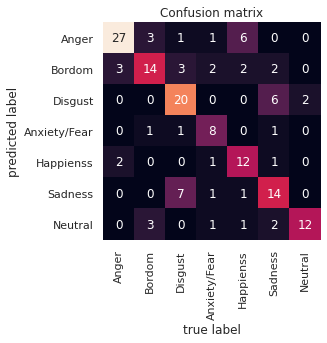

In [ ]:
# 1. using only IP
esn = ESN(x_train, y_train, teacher_forcing=False)
pred_train = esn.esn_fit()
print(pred_train)
# print(pred_train)
print('Training scores:')
esn.score(y_train, pred_train)
print('============================\n')
pred_test = esn.esn_predict(x_test)
print('Testing scores:')
esn.score(y_test, pred_test)
print('============================\n')


# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index = argmax(pred_test, axis=1)
y_test_index = argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
emotion_range = ['Anger', 'Bordom', 'Disgust', 'Anxiety/Fear', 'Happienss', 'Sadness', 'Neutral']
mat = confusion_matrix(y_test_index, pred_test_index)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)


#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')

only teacher forcing....
Training scores:
the square root of the mean of squared errors =  0.3092110272615691
the accuracy =  97.32620320855615 %

only teacher forcing....
Testing scores:
the square root of the mean of squared errors =  0.3280574863710614
the accuracy =  68.32298136645963 %



Text(89.18, 0.5, 'predicted label')

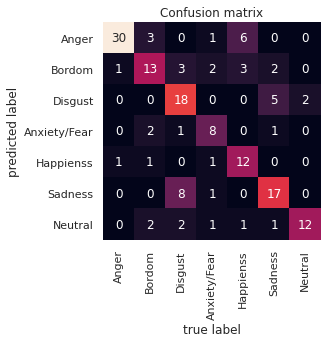

In [ ]:
# 2. using only teacher forcing
esn1 = ESN(x_train, y_train, IP=False)
pred_train1 = esn1.esn_fit()
print('Training scores:')
esn1.score(y_train, pred_train1)
print('============================\n')

pred_test1 = esn1.esn_predict(x_test)
print('Testing scores:')
esn1.score(y_test, pred_test1)
print('============================\n')


# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index1 = argmax(pred_test1, axis=1)
y_test_index1 = argmax(y_test, axis=1)

mat = confusion_matrix(y_test_index1, pred_test_index1)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')

with IP and teacher forcing....
Training scores:
the square root of the mean of squared errors =  0.31039526350764507
the accuracy =  95.18716577540107 %

with IP and teacher forcing....
Testing scores:
the square root of the mean of squared errors =  0.32839566976259693
the accuracy =  63.975155279503106 %



Text(89.18, 0.5, 'predicted label')

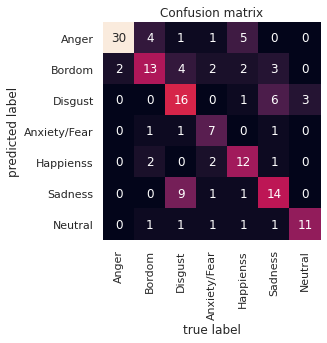

In [ ]:
# 3. using Both IP and teacher forcing
esn2 = ESN(x_train, y_train)
pred_train2 = esn2.esn_fit()
print('Training scores:')
esn2.score(y_train, pred_train2)
print('============================\n')

pred_test2 = esn2.esn_predict(x_test)
print('Testing scores:')
esn2.score(y_test, pred_test2)
print('============================\n')


# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index2 = argmax(pred_test2, axis=1)
y_test_index2 = argmax(y_test, axis=1)

mat = confusion_matrix(y_test_index2, pred_test_index2)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')

no IP, no teacher forcing....
Training scores:
the square root of the mean of squared errors =  0.3101561714327165
the accuracy =  96.79144385026738 %

no IP, no teacher forcing....
Testing scores:
the square root of the mean of squared errors =  0.3279318945863927
the accuracy =  64.59627329192547 %



Text(89.18, 0.5, 'predicted label')

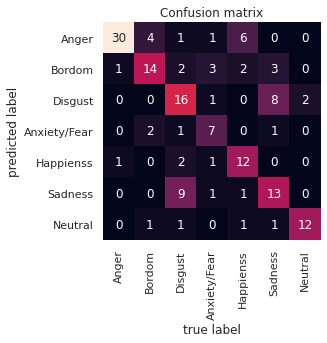

In [ ]:
# 4. without using neither IP nor teacher forcing
esn3 = ESN(x_train, y_train, IP=False, teacher_forcing=False)
pred_train3 = esn3.esn_fit()
print('Training scores:')
esn3.score(y_train, pred_train3)
print('============================\n')

pred_test3 = esn3.esn_predict(x_test)
print('Testing scores:')
esn3.score(y_test, pred_test3)
print('============================\n')


# get the index of the class with the highest probability
# because the confusion matrix accepts only 1d vector of digits
pred_test_index3 = argmax(pred_test3, axis=1)
y_test_index3 = argmax(y_test, axis=1)

mat = confusion_matrix(y_test_index3, pred_test_index3)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=emotion_range, yticklabels=emotion_range)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')